# Testing Model Prediction Stability Metrics 12-Aug-24

## Preamble

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(
    style='ticks', 
    context='notebook', 
    font_scale=0.8, 
    rc={'figure.figsize': (6,4)}
)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Roboto', 'Fira Sans']
rcParams['font.size'] = 10
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 'smaller'

In [64]:
import sklearn
# sklearn.set_config(transform_output="pandas")
sklearn.set_config(transform_output="default")
from sklearn.utils import check_array
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [65]:
from importlib import reload
import ml_model_stability
# reload(ml_moml_model_stability)
from ml_model_stability import (
    bootstrapped_model_prediction_stability,
    mean_pointwise_prediction_variance_Y,
    mean_pointwise_prediction_variance_M,
    get_Y_pred,
    plot_predicted_value_distributions
)

## Quick Data Loading and Preparation

In [66]:
ames_full = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/ML_Model_Stability/main/data/ames/train.csv'
)

In [67]:
cols_of_interest = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'SalePrice'
]
ames_sm = ames_full.loc[:, cols_of_interest]
ames_sm['SalePrice'] = ames_sm['SalePrice']/1000

In [68]:
X, y = ames_sm.drop(columns='SalePrice'), ames_sm['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Experimenting with Models and Stability Measuring

### A Default Random Forest

In [69]:
rfr = RandomForestRegressor()

In [70]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [71]:
cross_val_score(rfr, X_train, y_train)

array([0.80093512, 0.62207194, 0.88731881, 0.80568313, 0.9017126 ])

In [72]:
mean_div, std_div, divs, kdes, Y_pred, models = (
    bootstrapped_model_prediction_stability(rfr, X_train, y_train, X_test)
)

In [73]:
mean_div

0.001898582394723568

In [74]:
models

[RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor(),
 RandomForestRegressor()]

In [75]:
# each column is a distribution for a model; each row is a data point (X_test instances)
Y_pred[:5, :4]

array([[181.619     , 181.8507    , 175.936     , 153.4745    ],
       [284.61808   , 321.03839   , 284.36628   , 279.428     ],
       [139.98375   , 146.02426728, 144.86035   , 147.5510759 ],
       [191.32883   , 185.8687    , 179.921     , 174.437     ],
       [142.65752   , 138.70864   , 149.092     , 152.46309   ]])

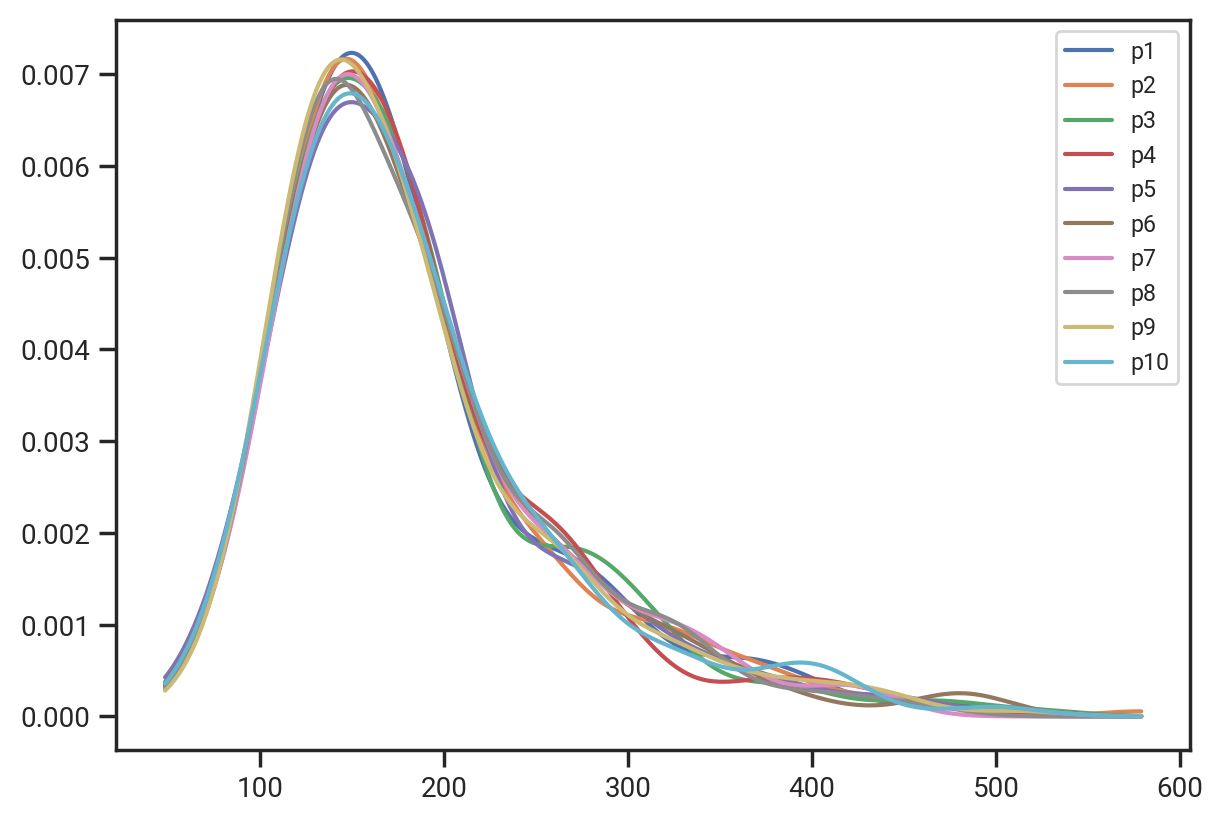

In [76]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax = plot_predicted_value_distributions(Y_pred, kdes, ax=ax)

In [77]:
mean_coef_var, std_coef_var, coefs_var = mean_pointwise_prediction_variance_M(models, X_test)

In [78]:
mean_coef_var

0.049689510435677146

In [79]:
# one coefficient of variance (over predictions from model variants)
# for each data point in X_test
coefs_var[:5]

array([0.09708862, 0.05574436, 0.0312051 , 0.06230311, 0.03601995])

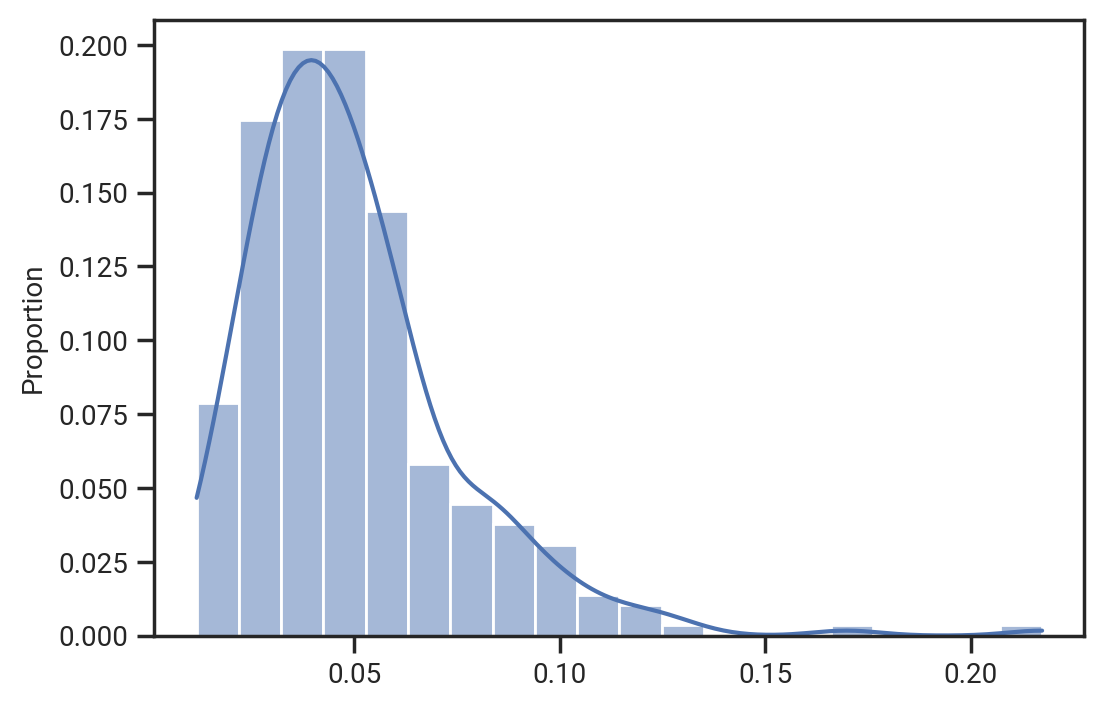

In [80]:
sns.histplot(coefs_var, kde=True, bins=20, stat='proportion');

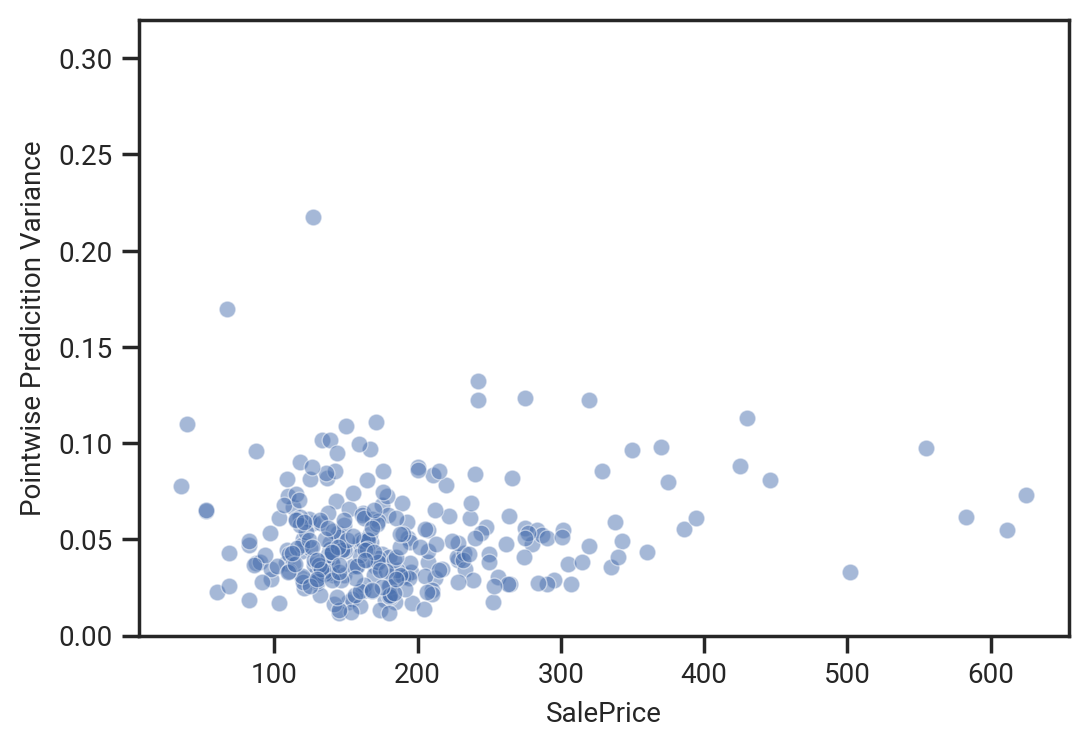

In [81]:
ax = sns.scatterplot(x=y_test, y=coefs_var, alpha=0.5)
ax.set_ylabel('Pointwise Predicition Variance')
ax.set_ylim(0, 0.32);

### A Better Random Forest

In [82]:
rfr = RandomForestRegressor(
    max_depth=8, min_samples_split=15, min_samples_leaf=8, n_estimators=400
)

In [83]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                      n_estimators=400)

In [84]:
cross_val_score(rfr, X_train, y_train)

array([0.76825866, 0.78558899, 0.83121254, 0.81560726, 0.84535496])

In [85]:
mean_div, std_div, divs, kdes, Y_pred, models = (
    bootstrapped_model_prediction_stability(rfr, X_train, y_train, X_test)
)

In [86]:
mean_div

0.0015274638366027343

In [87]:
models

[RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=15,
                       n_estimators=400),
 RandomForestRegressor(max_depth=8, min_

In [88]:
# each column is a distribution for a model; each row is a data point (X_test instances)
Y_pred[:5, :4]

array([[176.61087386, 179.2827549 , 188.9958726 , 179.73903115],
       [283.89367372, 284.13810508, 268.74902278, 273.2570002 ],
       [137.81828633, 135.70142918, 133.90032228, 135.69617488],
       [189.80356438, 176.53858394, 192.37568706, 190.39930778],
       [155.2053469 , 148.70069403, 157.7070109 , 144.57526425]])

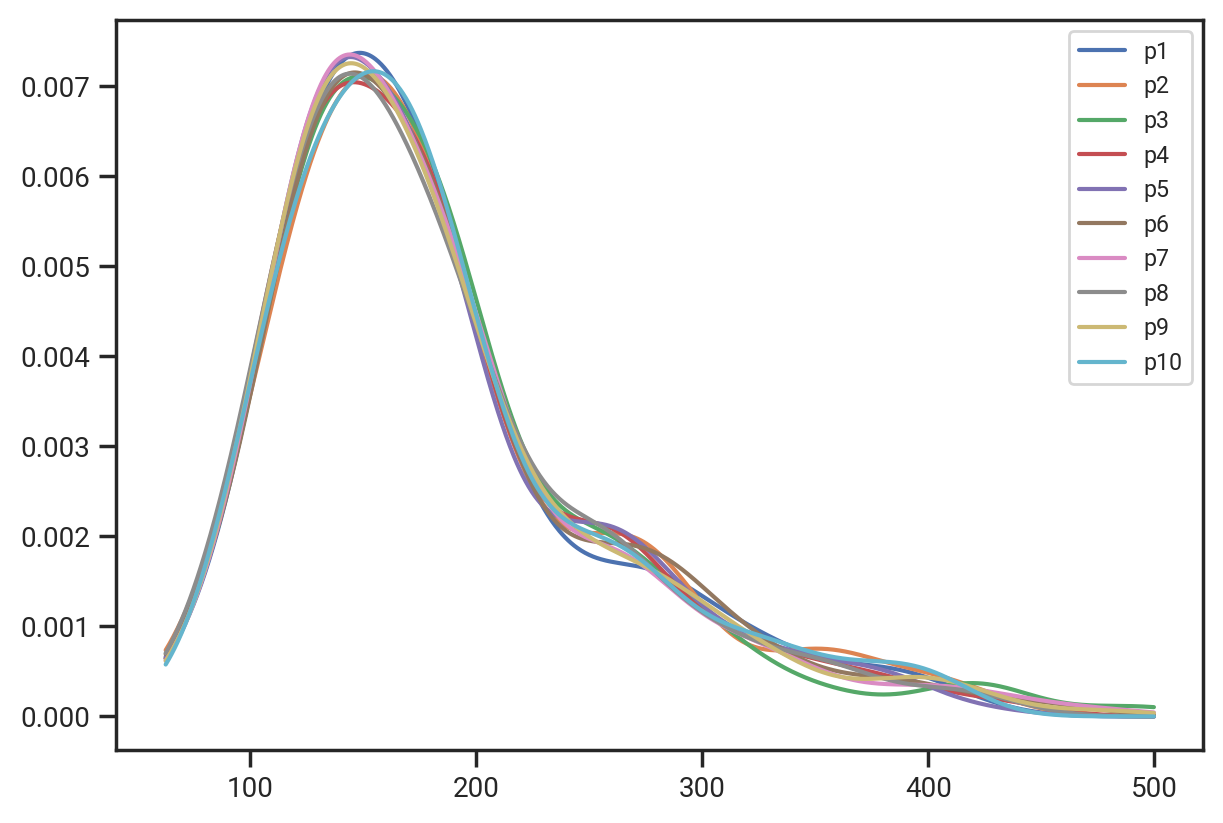

In [89]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax = plot_predicted_value_distributions(Y_pred, kdes, ax=ax)

In [90]:
mean_coef_var, std_coef_var, coefs_var = mean_pointwise_prediction_variance_M(models, X_test)

In [91]:
mean_coef_var

0.03922185381306525

In [92]:
# one coefficient of variance (over predictions from model variants)
# for each data point in X_test
coefs_var[:5]

array([0.03378672, 0.03520868, 0.01899768, 0.03192434, 0.05558528])

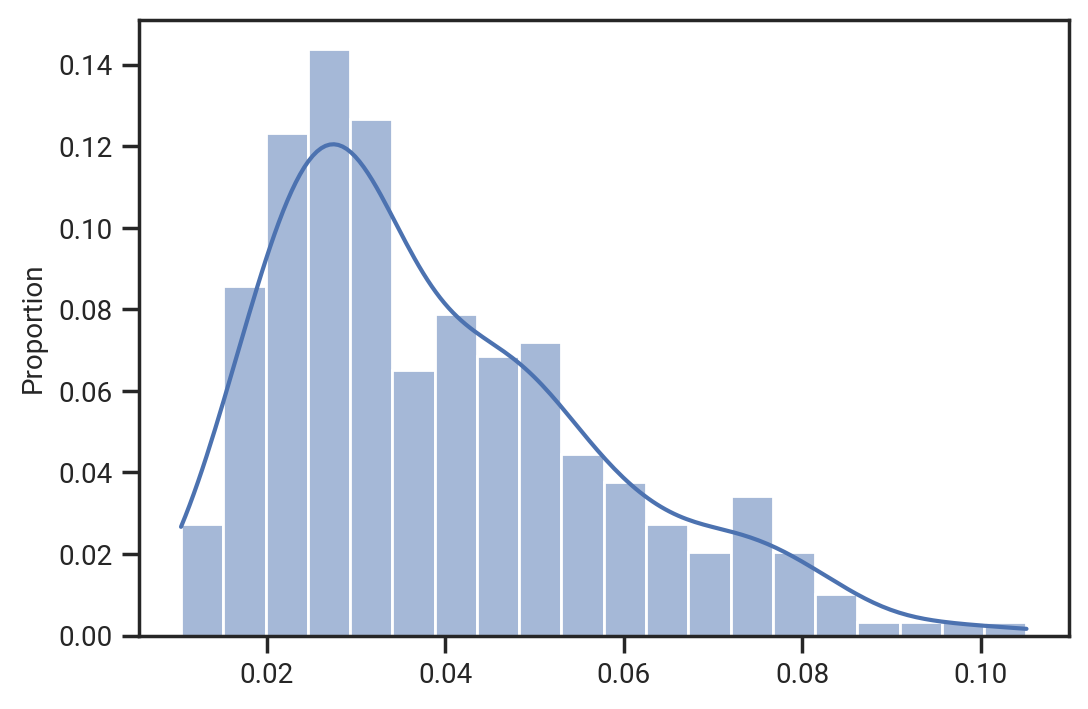

In [93]:
sns.histplot(coefs_var, kde=True, bins=20, stat='proportion');

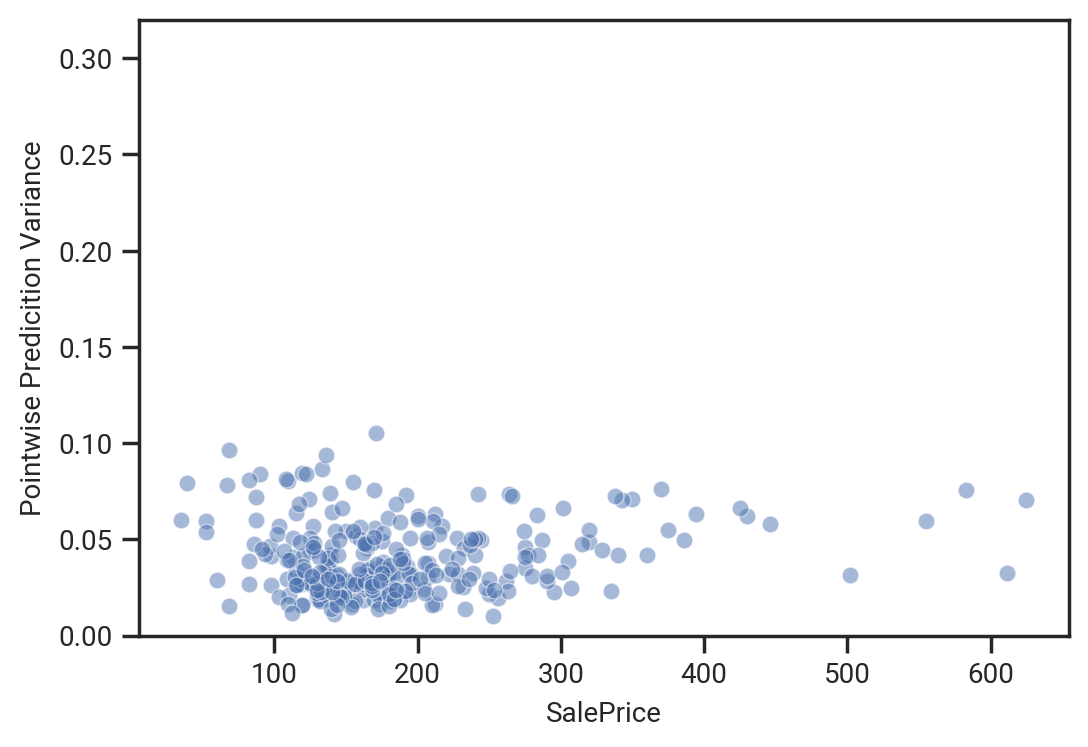

In [94]:
ax = sns.scatterplot(x=y_test, y=coefs_var, alpha=0.5)
ax.set_ylabel('Pointwise Predicition Variance')
ax.set_ylim(0, 0.32);

### A Default Decision Tree

In [95]:
dt = DecisionTreeRegressor()

In [96]:
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [97]:
cross_val_score(dt, X_train, y_train)

array([0.71718578, 0.46651797, 0.76087922, 0.68404859, 0.7955041 ])

In [98]:
mean_div, std_div, divs, kdes, Y_pred, models = (
    bootstrapped_model_prediction_stability(dt, X_train, y_train, X_test)
)

In [99]:
mean_div

0.003020681710750849

In [100]:
models

[DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor(),
 DecisionTreeRegressor()]

In [101]:
# each column is a distribution for a model; each row is a data point (X_test instances)
Y_pred[:5, :4]

array([[127.5       , 127.5       , 159.        , 127.5       ],
       [278.        , 266.        , 392.5       , 392.5       ],
       [146.82      , 150.46666667, 151.6       , 146.2       ],
       [ 82.5       , 193.        , 127.5       , 193.        ],
       [127.        , 126.        , 141.5       , 172.        ]])

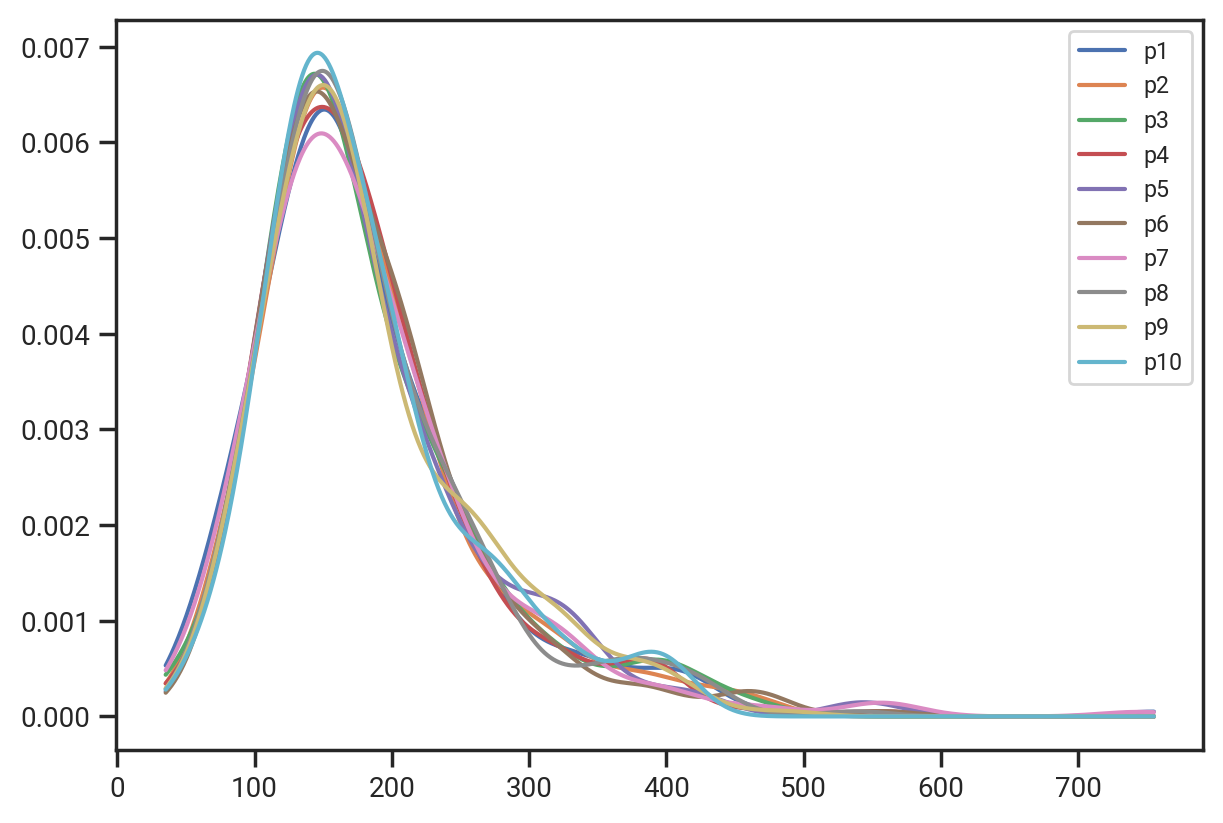

In [102]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax = plot_predicted_value_distributions(Y_pred, kdes, ax=ax)

In [103]:
mean_coef_var, std_coef_var, coefs_var = mean_pointwise_prediction_variance_M(models, X_test)

In [104]:
mean_coef_var

0.12900103879987204

In [105]:
# one coefficient of variance (over predictions from model variants)
# for each data point in X_test
coefs_var[:5]

array([0.10462483, 0.17953896, 0.0223113 , 0.21944587, 0.17261284])

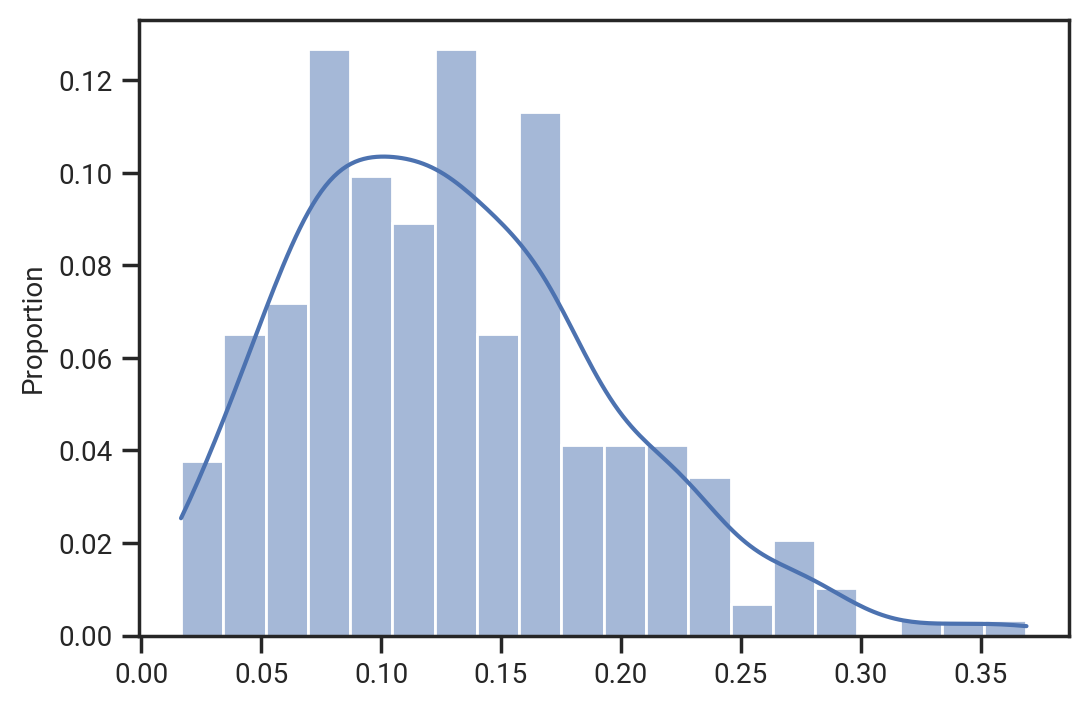

In [106]:
sns.histplot(coefs_var, kde=True, bins=20, stat='proportion');

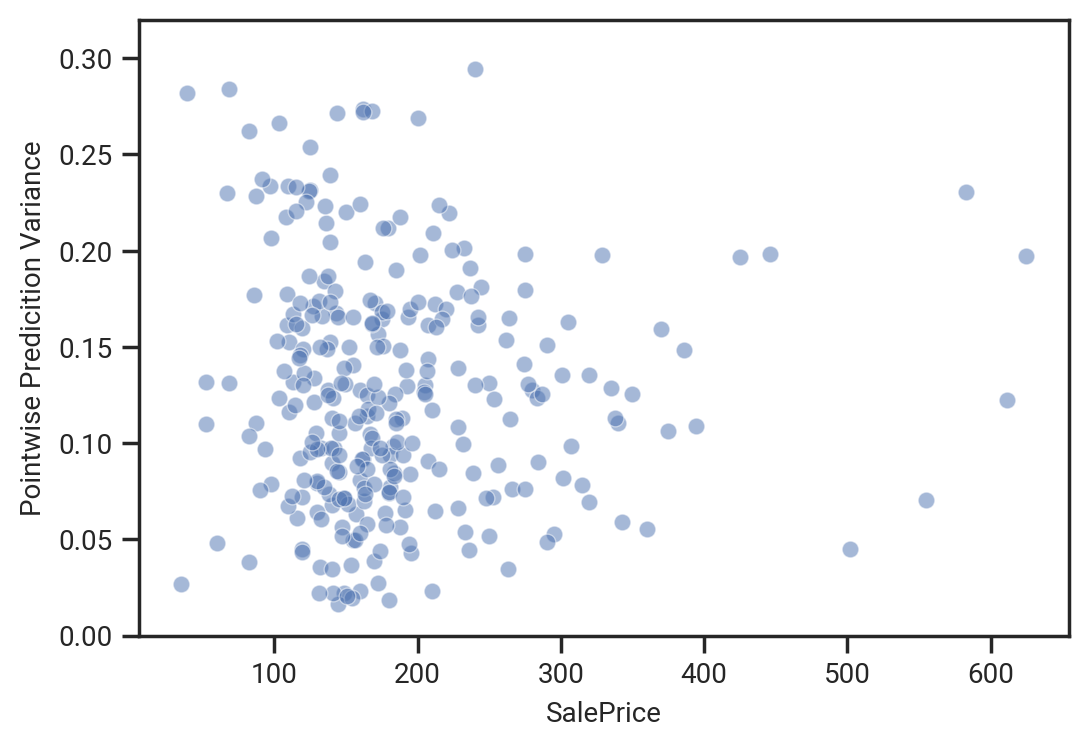

In [107]:
ax = sns.scatterplot(x=y_test, y=coefs_var, alpha=0.5)
ax.set_ylabel('Pointwise Predicition Variance')
ax.set_ylim(0, 0.32);